In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [2]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
v = stepmodel.read_json(model_path + 'de_volumes')
sm.volumes = v.volumes

In [5]:
sm.segments = [c for c in sm.volumes.columns if c not in ['origin', 'destination']]

In [6]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [7]:
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [8]:
# Rename columns that were confused through json export
column_dict = {"('"+seg+"', 'probability')": (seg, 'probability') for seg in sm.segments}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [11]:
# Load logit step probabilities to enrich LoS tables
'''logit = stepmodel.read_json(model_path + 'de_logit')
probs = logit.probabilities.set_index(['origin', 'destination', 'segment'])[
    ['walk', 'car', 'air', 'bus', 'coach', 'rail_short', 'rail_long']
].stack().rename('probability').unstack('segment')
probs.index.rename(['origin', 'destination', 'route_type'], inplace=True)

sm.pt_los = pt.pt_los.merge(probs, how='left',
    on=['origin', 'destination', 'route_type']
).rename(columns={seg: (seg, 'probability') for seg in sm.segments})

sm.car_los = car.car_los.merge(probs, how='left',
    on=['origin', 'destination', 'route_type']
).rename(columns={seg: (seg, 'probability') for seg in sm.segments})'''
print('This step is necessary if enriched LoS tables were not saved in the logit step')

This step is necessary if enriched LoS tables were not saved in the logit step


In [9]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [10]:
sm.pt_los.sample(2)

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
index,,,,,,,,,,,,,,,,,,,,,
21327,1502,0.788051,DEB32,0,900,397450,"(bus_1282285, bus_2136498, bus_2853583, bus_21...",5,DE11C,None,...,-2.922412,0.138357,-3.259761,-3.497996,-3.368179,0.255818,0.467424,0.201361,0.046632,0.077495
601852,2732,0.000000,DE735,0,8880,245976,"(r_l_4329, r_l_4330, r_l_4331, r_l_4332, r_l_5...",1,DEB36,None,...,-6.409963,-3.566417,-7.169143,-4.060957,-4.770478,0.002169,0.000129,0.000637,0.012524,0.009773


In [12]:
# Repair route_types if they are the same as route_type
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(lambda p: tuple(p))
if len(sm.pt_los['route_types'].unique())==len(sm.pt_los['route_type'].unique()):
    type_dict = sm.links['route_type'].to_dict()
    sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                                for l in list(sm.pt_los['link_path'])]

In [13]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

## Assignment

In [14]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [01:54<00:00, 22.86s/it]


In [15]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.91s/it]


In [16]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [17]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,"(load, bus)","(load, rail_long)","(load, rail_short)","(load, coach)","(load, air)","(load, walk)",load
index,,,,,,,,,,,,,,,,,,
bus_1856024,DEG0I_bus_0,DEG0K_bus_0,bus,"LINESTRING (11.41781 50.63275, 11.71442 50.58498)",1,bus_14118,120,bus_484882,38068,600,0.0,1817.55186,0.0,0.0,17.74914,0.0,0.0,1835.301


In [18]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,geometry,maxspeed,lanes,highway,length,"(Fz1, car)","(Fz2, car)","(Fz3, car)","(Fz4, car)","(Fz6, car)","(all, car)"
index,,,,,,,,,,,,,
rl_466877,14917197,264165869,"LINESTRING (8.02358 48.38936, 8.02015 48.34561)","[100, 80]","[2, 5, 3]",trunk,5173,1.835265e+06,174394.344998,2.386986e+06,1.052786e+06,3.047436e+06,8.496868e+06


In [19]:
sm.los.sample()

,index,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,...,"(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)",Fz1,Fz2,Fz3,Fz4,Fz6,volume
788618,788618,600,0.0,DE117,NaT,15878,372831,"(rl_448394, rl_244984, rl_135185, rl_135177, r...",0,DE227,...,0.021072,0.258382,0.673032,0.574075,0.0,0.0,0.0,53.169497,827.242124,880.411621


<AxesSubplot:>

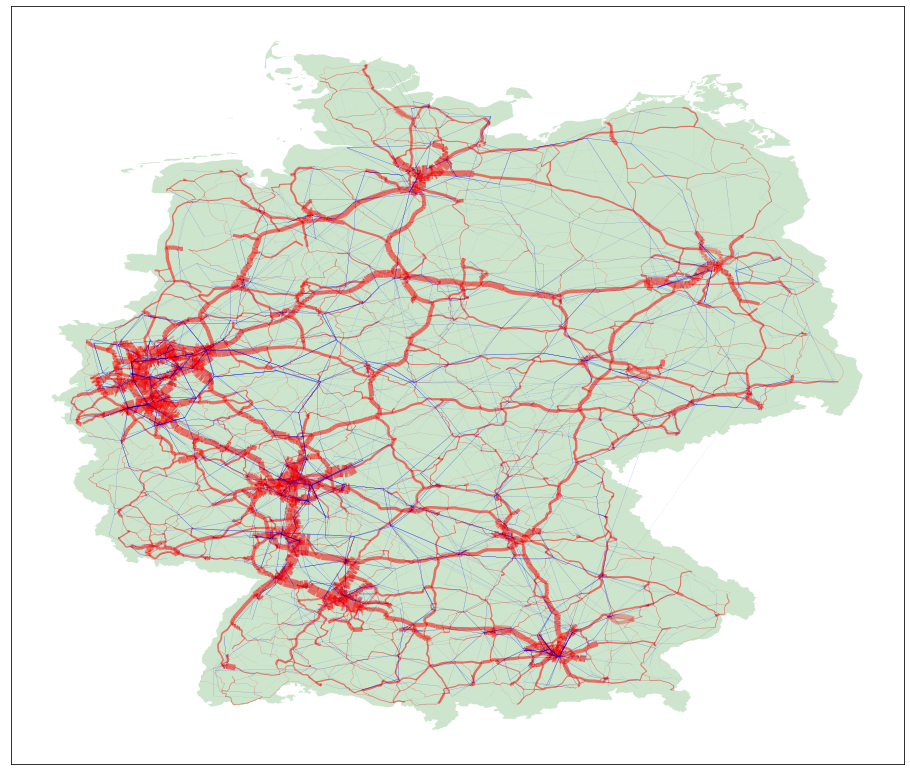

In [20]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

### Validation

In [21]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

In [22]:
diff['diff'].mean()

2.298950613690461e-07

<AxesSubplot:>

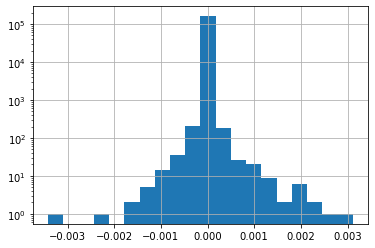

In [23]:
diff['diff'].hist(bins=20, log=True)

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [24]:
# Summary of LoS table
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # hours per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [25]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

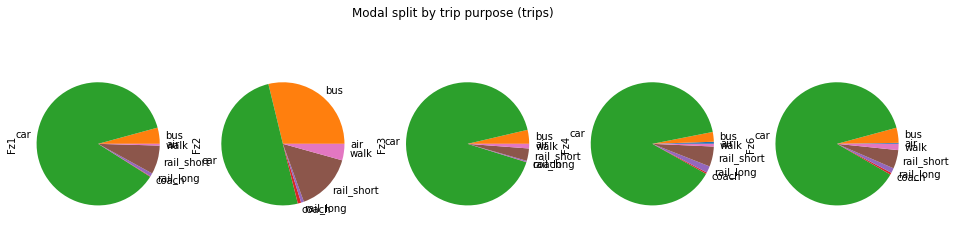

In [26]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

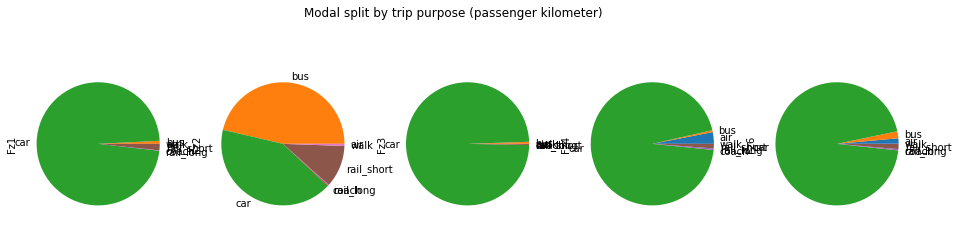

In [27]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

Volumes by mode and distance class


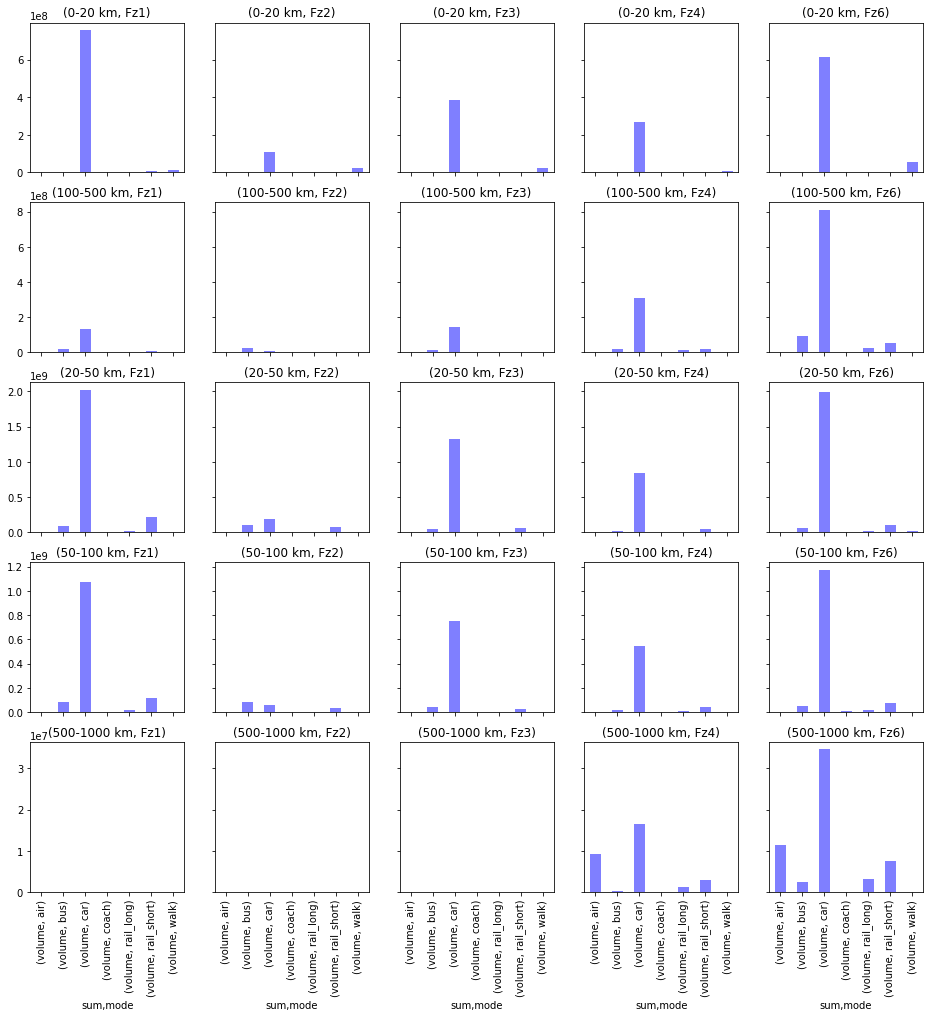

In [47]:
od = od_sum[[(seg, 'volume') for seg in sm.segments]].unstack('mode')
bins = [0, 20, 50, 100, 500, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])['length'] / 1000
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True,
                             right_index=True)['length'], bins=bins,
                    labels=['{}-{} km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,16), sharex='all', sharey='row')
od.sort_values('bins').groupby('bins').sum(axis=0).stack('segment').T.plot.bar(
    ax=ax, subplots=True, legend=False, color='blue', alpha=0.5)
print('Volumes by mode and distance class')

In [29]:
# Keep only the sum of all purposes
od = od_sum.loc[:, 'root']

In [30]:
# Aggregated modal split
od.groupby(level=2).sum(axis=1)['pkm'] / 1e6

mode
air             8126.314014
bus            15279.832683
car           657388.507268
coach             85.192481
rail_long       1701.278787
rail_short      9936.102780
walk             295.343260
Name: pkm, dtype: float64

## Save model

In [31]:
with pd.ExcelWriter(output_path + 'stacks.xlsx') as writer:  
    od.to_excel(writer, sheet_name='od_sum')

In [32]:
sm.to_json(model_path + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links', 'los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [03:47<00:00,  5.99s/it]
